<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, backtest_plot_mod, get_daily_return, get_baseline
from pprint import pprint

import sys
#sys.path.append("../FinRL-Library")

import itertools
import os

import pickle

/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
%matplotlib inline

<a id='2'></a>
# Part 3. Get Data


In [3]:
input_data_path = '../data'
input_data_filename = 'binance_BTCUSDT_15m_from_2020_01_01_to_2021_12_31_candlesticks_signals_processed_technical_indicators_and_crypto_index_v2'
input_data_extension = ".csv"
full_path_input_data = os.path.join(input_data_path, input_data_filename + input_data_extension)

In [4]:
df = pd.read_csv(full_path_input_data)

In [5]:
df.shape

(69805, 92)

In [6]:
df.head()

,time,open_time,open,high,low,close,volume,close_time,quote_asset_volumne,number_of_trades,...,AD,ATR,HT_DC,SAR,ratio_high_open,ratio_low_open,ratio_close_open,time_to_chart_return,crypto_index,datetime
0,2020-01-02 07:00:00,1577944800000,7138.93,7144.98,7135.00,7138.90,154.330095,1577945699999,1.101881e+06,1732,...,-171.772047,16.210334,25.653704,7148.920000,1.000847,0.999449,0.999996,-0.000004,999.995798,2020-01-02 07:00:00
1,2020-01-02 07:15:00,1577945700000,7138.90,7149.00,7138.50,7146.58,178.369024,1577946599999,1.274135e+06,1738,...,-75.622649,15.802453,27.065789,7116.700000,1.001415,0.999944,1.001076,0.001076,1001.071589,2020-01-02 07:15:00
2,2020-01-02 07:30:00,1577946600000,7145.96,7149.02,7136.41,7136.81,142.773244,1577947499999,1.019787e+06,1650,...,-209.338114,15.574421,27.707202,7117.346000,1.000428,0.998664,0.998720,-0.001367,999.703037,2020-01-02 07:30:00
3,2020-01-02 07:45:00,1577947500000,7136.42,7139.14,7121.43,7135.97,212.128302,1577948399999,1.512872e+06,2549,...,-73.149588,15.726962,27.658012,7118.612960,1.000381,0.997900,0.999937,-0.000118,999.585372,2020-01-02 07:45:00
4,2020-01-02 08:00:00,1577948400000,7136.04,7140.63,7121.01,7125.26,243.045551,1577949299999,1.732451e+06,2848,...,-210.900175,16.005036,27.255142,7119.829242,1.000643,0.997894,0.998489,-0.001501,998.085147,2020-01-02 08:00:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69805 entries, 0 to 69804
Data columns (total 92 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   time                          69805 non-null  object 
 1   open_time                     69805 non-null  int64  
 2   open                          69805 non-null  float64
 3   high                          69805 non-null  float64
 4   low                           69805 non-null  float64
 5   close                         69805 non-null  float64
 6   volume                        69805 non-null  float64
 7   close_time                    69805 non-null  int64  
 8   quote_asset_volumne           69805 non-null  float64
 9   number_of_trades              69805 non-null  int64  
 10  taker_buy_base_asset_volume   69805 non-null  float64
 11  taker_buy_quote_asset_volume  69805 non-null  float64
 12  ignore                        69805 non-null  int64  
 13  f

In [8]:
df.columns

Index(['time', 'open_time', 'open', 'high', 'low', 'close', 'volume',
       'close_time', 'quote_asset_volumne', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore',
       'formatted_open_time', 'formatted_close_time', 'upper_shadow',
       'lower_shadow', 'real_body', 'CDLINVERTEDHAMMER', 'CDLHAMMER',
       'CDLPIERCING', 'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR', 'CDLHANGINGMAN',
       'CDLDARKCLOUDCOVER', 'CDLEVENINGSTAR', 'CDLENGULFING',
       'CDLENGULFINGBULLISH', 'CDLENGULFINGBEARISH', 'CDLINVERTEDHAMMER_NEW',
       'CDLHAMMER_NEW', 'CDLPIERCING_NEW', 'CDLMORNINGSTAR_NEW',
       'CDLENGULFINGBULLISH_NEW', 'CDLSHOOTINGSTAR_NEW', 'CDLHANGINGMAN_NEW',
       'CDLDARKCLOUDCOVER_NEW', 'CDLEVENINGSTAR_NEW',
       'CDLENGULFINGBEARISH_NEW', 'MA5', 'MA10', 'MA20', 'MA60', 'MA120',
       'volume_MA5', 'volume_MA10', 'volume_MA20', 'SMA5', 'SMA10', 'SMA20',
       'SMA60', 'SMA120', 'volume_SMA5', 'volume_SMA10', 'volume_SMA20',
       'W

In [9]:
df.rename(columns = {'time':'date'}, inplace = True)
# df.rename(columns = {'formatted_open_time':'date'}, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69805 entries, 0 to 69804
Data columns (total 92 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          69805 non-null  object 
 1   open_time                     69805 non-null  int64  
 2   open                          69805 non-null  float64
 3   high                          69805 non-null  float64
 4   low                           69805 non-null  float64
 5   close                         69805 non-null  float64
 6   volume                        69805 non-null  float64
 7   close_time                    69805 non-null  int64  
 8   quote_asset_volumne           69805 non-null  float64
 9   number_of_trades              69805 non-null  int64  
 10  taker_buy_base_asset_volume   69805 non-null  float64
 11  taker_buy_quote_asset_volume  69805 non-null  float64
 12  ignore                        69805 non-null  int64  
 13  f

In [11]:
df["tic"] = 'BTCUSDT'

In [12]:
#df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d").dt.date

In [13]:
df_col_selected = df[['date', 'tic', 'open', 'high', 'low', 'close', 'volume',
        'upper_shadow', 'lower_shadow', 'real_body',
        'MACD_12_26_9', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'RSI_14', 'CCI_14', 'WMA20', 'WMA60',
        'CDLINVERTEDHAMMER_NEW', 'CDLHAMMER_NEW', 'CDLMORNINGSTAR_NEW', 'CDLENGULFINGBULLISH_NEW', 
        'CDLSHOOTINGSTAR_NEW', 'CDLHANGINGMAN_NEW', 'CDLEVENINGSTAR_NEW', 'CDLENGULFINGBEARISH_NEW']]

In [14]:
df_col_selected.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2020-01-02 07:00:00,BTCUSDT,7138.93,7144.98,7135.00,7138.90,154.330095,6.05,3.90,0.03,...,7147.086143,7182.061661,0,0,0,0,0,0,0,0
1,2020-01-02 07:15:00,BTCUSDT,7138.90,7149.00,7138.50,7146.58,178.369024,2.42,0.40,7.68,...,7146.188286,7180.275464,0,0,0,0,0,0,0,0
2,2020-01-02 07:30:00,BTCUSDT,7145.96,7149.02,7136.41,7136.81,142.773244,3.06,0.40,9.15,...,7144.567571,7178.213503,0,0,0,0,0,0,0,0
3,2020-01-02 07:45:00,BTCUSDT,7136.42,7139.14,7121.43,7135.97,212.128302,2.72,14.54,0.45,...,7143.119000,7176.178202,0,0,0,0,0,0,0,0
4,2020-01-02 08:00:00,BTCUSDT,7136.04,7140.63,7121.01,7125.26,243.045551,4.59,4.25,10.78,...,7140.912429,7173.845426,0,0,0,0,0,0,0,0


In [15]:
df_col_selected.tail()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
69800,2021-12-31 00:00:00,BTCUSDT,47084.88,47240.0,46987.99,47110.36,235.14202,129.64,96.89,25.48,...,47288.419190,47389.988148,0,0,0,0,0,0,0,0
69801,2021-12-31 00:15:00,BTCUSDT,47110.36,47242.6,47040.81,47122.27,179.83497,120.33,69.55,11.91,...,47259.175618,47383.627191,0,0,0,0,0,0,0,0
69802,2021-12-31 00:30:00,BTCUSDT,47122.28,47160.0,46940.96,47092.12,198.46904,37.72,151.16,30.16,...,47229.788570,47376.198716,0,0,0,0,0,0,0,0
69803,2021-12-31 00:45:00,BTCUSDT,47092.12,47177.3,47044.16,47120.87,96.74091,56.43,47.96,28.75,...,47205.648856,47369.590945,0,0,0,0,0,0,0,0
69804,2021-12-31 01:00:00,BTCUSDT,47120.88,47500.0,47080.00,47296.76,379.28228,203.24,40.88,175.88,...,47201.783809,47368.572399,0,0,0,0,0,0,0,0


In [16]:
#df_col_selected.plot(x='date', y='close')
df_col_selected.isna().any().any()

False

### Check missing date

In [17]:
df_check_date = df_col_selected[['date']]

In [18]:
# Setting the Date values as index
df_check_date = df_check_date.set_index('date')
 
# to_datetime() method converts string
# format to a DateTime object
df_check_date.index = pd.to_datetime(df_check_date.index)
 
# dates which are not in the sequence
# are returned
print(pd.date_range(
  start="2017-12-15", end="2021-12-31").difference(df_check_date.index))

DatetimeIndex(['2017-12-15', '2017-12-16', '2017-12-17', '2017-12-18',
               '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24',
               ...
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31',
               '2020-01-01', '2020-01-02'],
              dtype='datetime64[ns]', length=749, freq=None)


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [19]:
fe = FeatureEngineer(
                    use_technical_indicator=False,
                    #tech_indicator_list = ["macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", "close_30_sma", "close_60_sma"],
                    use_vix=False,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df_col_selected)

In [20]:
processed.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2020-01-02 07:00:00,BTCUSDT,7138.93,7144.98,7135.00,7138.90,154.330095,6.05,3.90,0.03,...,7147.086143,7182.061661,0,0,0,0,0,0,0,0
1,2020-01-02 07:15:00,BTCUSDT,7138.90,7149.00,7138.50,7146.58,178.369024,2.42,0.40,7.68,...,7146.188286,7180.275464,0,0,0,0,0,0,0,0
2,2020-01-02 07:30:00,BTCUSDT,7145.96,7149.02,7136.41,7136.81,142.773244,3.06,0.40,9.15,...,7144.567571,7178.213503,0,0,0,0,0,0,0,0
3,2020-01-02 07:45:00,BTCUSDT,7136.42,7139.14,7121.43,7135.97,212.128302,2.72,14.54,0.45,...,7143.119000,7176.178202,0,0,0,0,0,0,0,0
4,2020-01-02 08:00:00,BTCUSDT,7136.04,7140.63,7121.01,7125.26,243.045551,4.59,4.25,10.78,...,7140.912429,7173.845426,0,0,0,0,0,0,0,0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [21]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69805 entries, 0 to 69804
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     69805 non-null  object 
 1   tic                      69805 non-null  object 
 2   open                     69805 non-null  float64
 3   high                     69805 non-null  float64
 4   low                      69805 non-null  float64
 5   close                    69805 non-null  float64
 6   volume                   69805 non-null  float64
 7   upper_shadow             69805 non-null  float64
 8   lower_shadow             69805 non-null  float64
 9   real_body                69805 non-null  float64
 10  MACD_12_26_9             69805 non-null  float64
 11  BBANDS_U                 69805 non-null  float64
 12  BBANDS_M                 69805 non-null  float64
 13  BBANDS_L                 69805 non-null  float64
 14  RSI_14                

## Training data split:
## Trade data split:

In [22]:
train = data_split(processed, '2020-01-01','2021-06-30')
trade = data_split(processed, '2021-06-30','2021-12-30')
print(len(train))
print(len(trade))

52162
17542


In [23]:
train.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2020-01-02 07:00:00,BTCUSDT,7138.93,7144.98,7135.00,7138.90,154.330095,6.05,3.90,0.03,...,7147.086143,7182.061661,0,0,0,0,0,0,0,0
1,2020-01-02 07:15:00,BTCUSDT,7138.90,7149.00,7138.50,7146.58,178.369024,2.42,0.40,7.68,...,7146.188286,7180.275464,0,0,0,0,0,0,0,0
2,2020-01-02 07:30:00,BTCUSDT,7145.96,7149.02,7136.41,7136.81,142.773244,3.06,0.40,9.15,...,7144.567571,7178.213503,0,0,0,0,0,0,0,0
3,2020-01-02 07:45:00,BTCUSDT,7136.42,7139.14,7121.43,7135.97,212.128302,2.72,14.54,0.45,...,7143.119000,7176.178202,0,0,0,0,0,0,0,0
4,2020-01-02 08:00:00,BTCUSDT,7136.04,7140.63,7121.01,7125.26,243.045551,4.59,4.25,10.78,...,7140.912429,7173.845426,0,0,0,0,0,0,0,0


In [24]:
train.tail()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
52157,2021-06-29 22:45:00,BTCUSDT,36304.01,36353.22,36099.79,36156.04,1169.164899,49.21,56.25,147.97,...,36306.685952,36096.858683,0,0,0,0,0,0,0,0
52158,2021-06-29 23:00:00,BTCUSDT,36156.03,36276.86,36111.43,36119.08,554.280997,120.83,7.65,36.95,...,36288.551619,36106.795257,0,0,0,0,0,0,0,0
52159,2021-06-29 23:15:00,BTCUSDT,36119.09,36242.50,36106.46,36132.73,475.188271,109.77,12.63,13.64,...,36272.036809,36116.402180,0,0,0,0,0,0,0,0
52160,2021-06-29 23:30:00,BTCUSDT,36132.73,36273.08,36126.54,36261.84,493.900978,11.24,6.19,129.11,...,36268.710619,36129.587295,0,0,0,0,0,0,0,0
52161,2021-06-29 23:45:00,BTCUSDT,36263.77,36323.76,36228.00,36240.01,459.540654,59.99,12.01,23.76,...,36263.633476,36141.367137,0,0,0,0,0,0,0,0


In [25]:
trade.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2021-06-30 00:00:00,BTCUSDT,36240.01,36268.96,35963.01,36008.22,800.673290,28.95,45.21,231.79,...,36236.966238,36145.051464,0,0,0,0,0,0,0,0
1,2021-06-30 00:15:00,BTCUSDT,36008.23,36089.33,35700.01,35757.27,1524.930157,81.10,57.26,250.96,...,36188.155381,36140.125410,0,0,0,0,0,0,0,0
2,2021-06-30 00:30:00,BTCUSDT,35757.27,35973.79,35753.42,35944.57,930.759811,29.22,3.85,187.30,...,36160.266714,36141.047115,0,0,0,0,0,0,0,0
3,2021-06-30 00:45:00,BTCUSDT,35944.57,36189.81,35925.00,35925.00,654.603595,245.24,0.00,19.57,...,36132.492904,36140.838628,0,0,0,0,0,0,0,0
4,2021-06-30 01:00:00,BTCUSDT,35924.99,36050.00,35862.16,35862.17,610.343883,125.01,0.01,62.82,...,36100.855285,36137.982311,0,0,0,0,0,0,0,0


In [26]:
trade.tail()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
17537,2021-12-29 22:45:00,BTCUSDT,47227.70,47272.99,47135.00,47230.00,320.66696,42.99,92.70,2.30,...,47334.396332,47458.996552,0,0,0,0,0,0,0,0
17538,2021-12-29 23:00:00,BTCUSDT,47230.00,47230.00,47100.00,47178.33,245.95675,0.00,78.33,51.67,...,47311.812237,47448.334229,0,1,0,0,0,0,0,0
17539,2021-12-29 23:15:00,BTCUSDT,47178.34,47389.86,47177.22,47362.05,207.12594,27.81,1.12,183.71,...,47309.015380,47443.951623,0,0,0,0,0,0,0,0
17540,2021-12-29 23:30:00,BTCUSDT,47362.05,47488.38,47302.16,47428.74,197.95416,59.64,59.89,66.69,...,47313.812332,47441.901541,0,0,0,0,0,0,0,0
17541,2021-12-29 23:45:00,BTCUSDT,47428.76,47428.76,47182.52,47274.61,208.73972,0.00,92.09,154.15,...,47305.127332,47434.897229,0,0,0,0,0,0,0,-1


In [27]:
#list_indicators = ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
list_indicators = ['upper_shadow', 'lower_shadow', 'real_body',
        'MACD_12_26_9', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'RSI_14', 'CCI_14', 'WMA20', 'WMA60',
        'CDLINVERTEDHAMMER_NEW', 'CDLHAMMER_NEW', 'CDLMORNINGSTAR_NEW', 'CDLENGULFINGBULLISH_NEW', 
        'CDLSHOOTINGSTAR_NEW', 'CDLHANGINGMAN_NEW', 'CDLEVENINGSTAR_NEW', 'CDLENGULFINGBEARISH_NEW']

In [28]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(list_indicators) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 22


In [29]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount" : 1000000,
    "num_stock_shares": stock_dimension,
    # buy and sell cost for each stock
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": list_indicators, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [30]:
print(env_kwargs)

{'hmax': 100, 'initial_amount': 1000000, 'num_stock_shares': 1, 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'state_space': 22, 'stock_dim': 1, 'tech_indicator_list': ['upper_shadow', 'lower_shadow', 'real_body', 'MACD_12_26_9', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'RSI_14', 'CCI_14', 'WMA20', 'WMA60', 'CDLINVERTEDHAMMER_NEW', 'CDLHAMMER_NEW', 'CDLMORNINGSTAR_NEW', 'CDLENGULFINGBULLISH_NEW', 'CDLSHOOTINGSTAR_NEW', 'CDLHANGINGMAN_NEW', 'CDLEVENINGSTAR_NEW', 'CDLENGULFINGBEARISH_NEW'], 'action_space': 1, 'reward_scaling': 0.0001}


## Environment for Training



In [31]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [32]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

In [ ]:
# full_path_export_model_a2c = '../models/finrl_stocktrading_neurips_2018_mod_a2c.pkl'

# # Open a file and use dump()
# with open(full_path_export_model_a2c, 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(trained_a2c, file, protocol=pickle.HIGHEST_PROTOCOL)

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

In [ ]:
# full_path_export_model_ddpg = '../models/finrl_stocktrading_neurips_2018_mod_ddpg.pkl'

# # Open a file and use dump()
# with open(full_path_export_model_ddpg, 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(trained_ddpg, file)

### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

### Model 5: SAC

In [33]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [34]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=10000)

## Trading
Assume that we have $1,000 initial capital at 2021-06-30. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [35]:
processed.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2020-01-02 07:00:00,BTCUSDT,7138.93,7144.98,7135.00,7138.90,154.330095,6.05,3.90,0.03,...,7147.086143,7182.061661,0,0,0,0,0,0,0,0
1,2020-01-02 07:15:00,BTCUSDT,7138.90,7149.00,7138.50,7146.58,178.369024,2.42,0.40,7.68,...,7146.188286,7180.275464,0,0,0,0,0,0,0,0
2,2020-01-02 07:30:00,BTCUSDT,7145.96,7149.02,7136.41,7136.81,142.773244,3.06,0.40,9.15,...,7144.567571,7178.213503,0,0,0,0,0,0,0,0
3,2020-01-02 07:45:00,BTCUSDT,7136.42,7139.14,7121.43,7135.97,212.128302,2.72,14.54,0.45,...,7143.119000,7176.178202,0,0,0,0,0,0,0,0
4,2020-01-02 08:00:00,BTCUSDT,7136.04,7140.63,7121.01,7125.26,243.045551,4.59,4.25,10.78,...,7140.912429,7173.845426,0,0,0,0,0,0,0,0


In [36]:
#data_risk_indicator = processed[(processed.date<'2021-07-01') & (processed.date>='2020-01-01')]
#insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [37]:
# e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [38]:
trade.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2021-06-30 00:00:00,BTCUSDT,36240.01,36268.96,35963.01,36008.22,800.673290,28.95,45.21,231.79,...,36236.966238,36145.051464,0,0,0,0,0,0,0,0
1,2021-06-30 00:15:00,BTCUSDT,36008.23,36089.33,35700.01,35757.27,1524.930157,81.10,57.26,250.96,...,36188.155381,36140.125410,0,0,0,0,0,0,0,0
2,2021-06-30 00:30:00,BTCUSDT,35757.27,35973.79,35753.42,35944.57,930.759811,29.22,3.85,187.30,...,36160.266714,36141.047115,0,0,0,0,0,0,0,0
3,2021-06-30 00:45:00,BTCUSDT,35944.57,36189.81,35925.00,35925.00,654.603595,245.24,0.00,19.57,...,36132.492904,36140.838628,0,0,0,0,0,0,0,0
4,2021-06-30 01:00:00,BTCUSDT,35924.99,36050.00,35862.16,35862.17,610.343883,125.01,0.01,62.82,...,36100.855285,36137.982311,0,0,0,0,0,0,0,0


In [39]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [40]:
df_account_value.shape

(17542, 2)

In [41]:
df_account_value.head()

,date,account_value
0,2021-06-30 00:00:00,1.036008e+06
1,2021-06-30 00:15:00,9.920387e+05
2,2021-06-30 00:30:00,9.972351e+05
3,2021-06-30 00:45:00,9.966922e+05
4,2021-06-30 01:00:00,9.949490e+05


In [42]:
df_account_value.tail()

,date,account_value
17537,2021-12-29 22:45:00,1.310335e+06
17538,2021-12-29 23:00:00,1.308901e+06
17539,2021-12-29 23:15:00,1.313998e+06
17540,2021-12-29 23:30:00,1.315848e+06
17541,2021-12-29 23:45:00,1.311572e+06


In [43]:
df_account_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17542 entries, 0 to 17541
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17542 non-null  object 
 1   account_value  17542 non-null  float64
dtypes: float64(1), object(1)
memory usage: 274.2+ KB


In [44]:
df_actions.head()

,date,actions
0,2021-06-30 00:00:00,[27]
1,2021-06-30 00:15:00,[0]
2,2021-06-30 00:30:00,[0]
3,2021-06-30 00:45:00,[0]
4,2021-06-30 01:00:00,[0]


In [45]:
df_actions.tail()

,date,actions
17536,2021-12-29 22:30:00,[0]
17537,2021-12-29 22:45:00,[0]
17538,2021-12-29 23:00:00,[0]
17539,2021-12-29 23:15:00,[0]
17540,2021-12-29 23:30:00,[0]


In [46]:
df_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17541 entries, 0 to 17540
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     17541 non-null  object
 1   actions  17541 non-null  object
dtypes: object(2)
memory usage: 274.2+ KB


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [47]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("results/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.003394
Cumulative returns     0.265986
Annual volatility      0.057165
Sharpe ratio           0.087883
Calmar ratio           0.010070
Stability              0.535850
Max drawdown          -0.337017
Omega ratio            1.016425
Sortino ratio          0.125005
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.034809
Daily value at risk   -0.007182
dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [48]:
#baseline stats
# print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

# stats = backtest_stats(baseline_df, value_col_name = 'close')

baseline_df = df[['date', 'tic', 'crypto_index']]
baseline_df.rename(columns = {'crypto_index':'close'}, inplace = True)
#baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y-%m-%d").dt.date
baseline_df.head()

,date,tic,close
0,2020-01-02 07:00:00,BTCUSDT,999.995798
1,2020-01-02 07:15:00,BTCUSDT,1001.071589
2,2020-01-02 07:30:00,BTCUSDT,999.703037
3,2020-01-02 07:45:00,BTCUSDT,999.585372
4,2020-01-02 08:00:00,BTCUSDT,998.085147


In [49]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69805 entries, 0 to 69804
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    69805 non-null  object 
 1   tic     69805 non-null  object 
 2   close   69805 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [50]:
stats = backtest_stats(baseline_df, value_col_name = 'close')

Annual return          0.006850
Cumulative returns     5.625217
Annual volatility      0.071977
Sharpe ratio           0.130730
Calmar ratio           0.010875
Stability              0.841683
Max drawdown          -0.629869
Omega ratio            1.028105
Sortino ratio          0.186669
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.015496
Daily value at risk   -0.009031
dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [51]:
df_account_value.loc[0,'date']

'2021-06-30 00:00:00'

In [52]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-12-29 23:45:00'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to Crypto Index===========


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2021-06-30
End date,2021-12-29
Total months,835
,Backtest
Annual return,0.339%
Cumulative returns,26.599%
Annual volatility,5.717%
Sharpe ratio,0.09
Calmar ratio,0.01
Stability,0.54
Max drawdown,-33.702%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.70,2021-11-10,2021-12-04,NaT,NaN
1,23.59,2021-09-07,2021-09-22,2021-10-06,22
2,21.21,2021-06-30,2021-07-20,2021-07-26,19
3,12.90,2021-10-20,2021-10-28,2021-11-09,14
4,11.19,2021-08-01,2021-08-04,2021-08-06,5


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_d

Stress Events,mean,min,max
New Normal,0.00%,-6.76%,3.66%


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


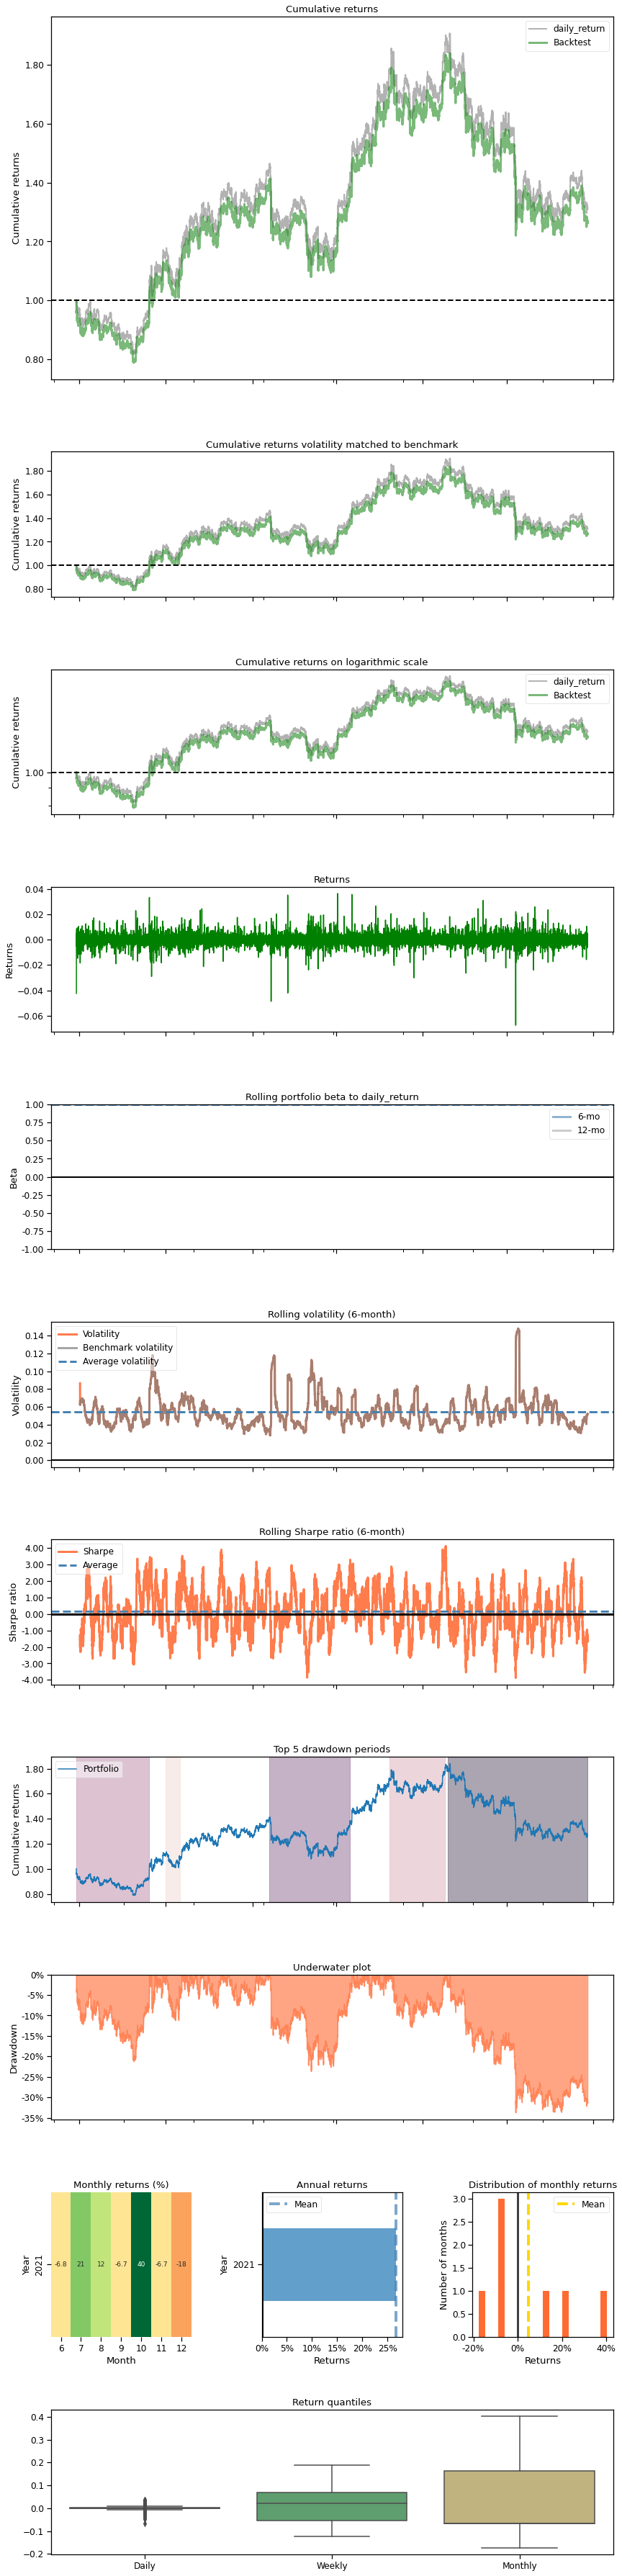

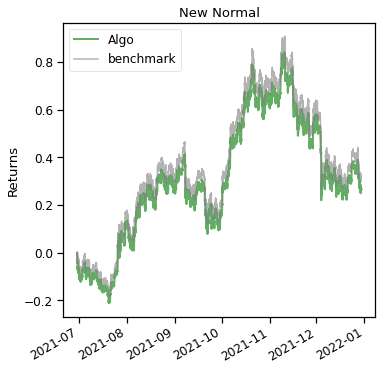

In [53]:
print("==============Compare to Crypto Index===========")
%matplotlib inline
backtest_plot_mod(df_account_value, baseline_df)

In [54]:
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#              baseline_ticker = '^DJI', 
#              baseline_start = df_account_value.loc[0,'date'],
#              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])